<a href="https://colab.research.google.com/github/harish-anandaramanujam/finetuning-qwen2.5-lora-qlora/blob/main/qlora_with_Qwen2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Finetuning Qwen2.5-7B-Instruct model using LoRA and QLoRA




In [ ]:
# pip installs

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q requests bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0
!pip install -q datasets requests peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB ? eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# imports

import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datetime import datetime

In [ ]:
# Constants

BASE_MODEL = "Qwen/Qwen2.5-7B-Instruct"

# Hyperparameters for QLoRA Fine-Tuning

LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]

### Log in to HuggingFace


In [ ]:
# Log in to HuggingFace

hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

## Analyzing the base model



In [ ]:
# Load the Base Model without quantization

base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL, device_map="auto")

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

In [ ]:
print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:,.1f} GB")

Memory footprint: 30.5 GB


In [ ]:
base_model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((3584,), eps=1e-06)
    (rotary_emb):

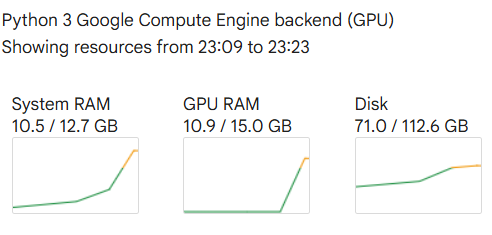

## Quantizing with 8 bits

In [ ]:
# Load the Base Model using 8 bit

quant_config = BitsAndBytesConfig(load_in_8bit=True)

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:,.1f} GB")

Memory footprint: 8.7 GB


In [ ]:
base_model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear8bitLt(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMS

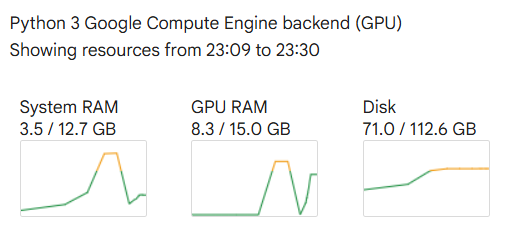

## Double Quantization with 4 bits

In [ ]:
# Load the Tokenizer and the Base Model using 4 bit

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4")

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:,.2f} GB")

Memory footprint: 5.44 GB


In [ ]:
base_model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((3584,), 

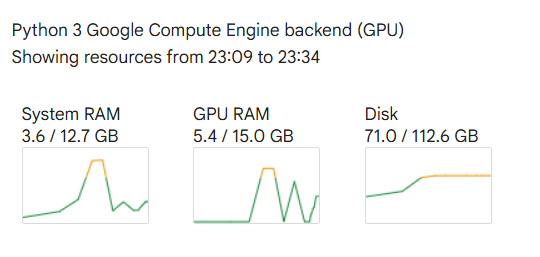